# Superposition

Last access (y.m.d): 19.08.29  
Last update (y.m.d): 19.08.29  

In this notebook, I'll look at truly testing the superposition aspect of the newer V1 experiments. In particular, for a given stimulus with dispersion > 1 (i.e. not just a single grating), the components of that stimulus will have been presented in isolation. This allows us to test $R_{1+2+..}$ against $R_1 + R_2 + ...$, where $_i$ are different stimulus components.

### Table of contents

- Example cell or experiment  
- All V1 data   


In [1]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses

import warnings
warnings.filterwarnings('once');

%matplotlib inline

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

basePath = os.getcwd() + '/'

In [2]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 8; # this is in style sheet, just being explicit
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 5; # no minor ticks
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 0; # no minor ticks

rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2;
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 0

rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Example cell or experiment

This section of code is used to look at just one cell or one experiment (e.g. all of V1_orig).

In this section, I outline some of the key components of the analysis and make helpful visualizations.

### Suppression index

In [3]:
## edit
expDir   = 'V1/';
dataListNm = 'dataList_glx.npy'
descrFits_f0 = 'descrFits_190503_sach_flex.npy';
rvcName = 'rvcFits_190828_f1'
# expDir   = 'altExp/';
# dataListNm = 'dataList.npy'

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [4]:
savePlt=0;
save_locSuper = save_loc + 'superposition/'
if not os.path.exists(save_locSuper):
    os.makedirs(save_locSuper)

In [44]:
# pick one cell?
cells = [6]; 

# or do all?
# cells = np.arange(1, 1+len(dataList['unitName']))

In [45]:
nan_rm = lambda x: x[~np.isnan(x)];
zr_rm = lambda x: x[x>0];
zr_rm_pair = lambda x, z: [x[np.logical_and(x>0, z>0)], z[np.logical_and(x>0, z>0)]];
# zr_rm_pair = lambda x, z: [x[np.logical_and(x>0, z>0)], z[np.logical_and(x>0, z>0)]] if np.logical_and(x!=[], z!=[])==True else [], [];

In [52]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [32]:
################
## DO YOU WANT TO RUN THIS?
## DEBUGGING new changes in tabulate_responses --- works!
################
resps_GT, stimVals_GT, val_con_by_disp_GT, _, _ = hf.tabulate_responses(expData, expInd);
resps_F0, stimVals_F0, val_con_by_disp_F0, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=expData['spikeCount']);
f1_sum = np.array([np.sum(x)for x in expData['f1']]);
resps_F1, stimVals_F1, val_con_by_disp_F1, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum);
f1_sum_adj = spikes
resps_F1_adj, stimVals_F1_adj, val_con_by_disp_F1_adj, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum_adj);

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


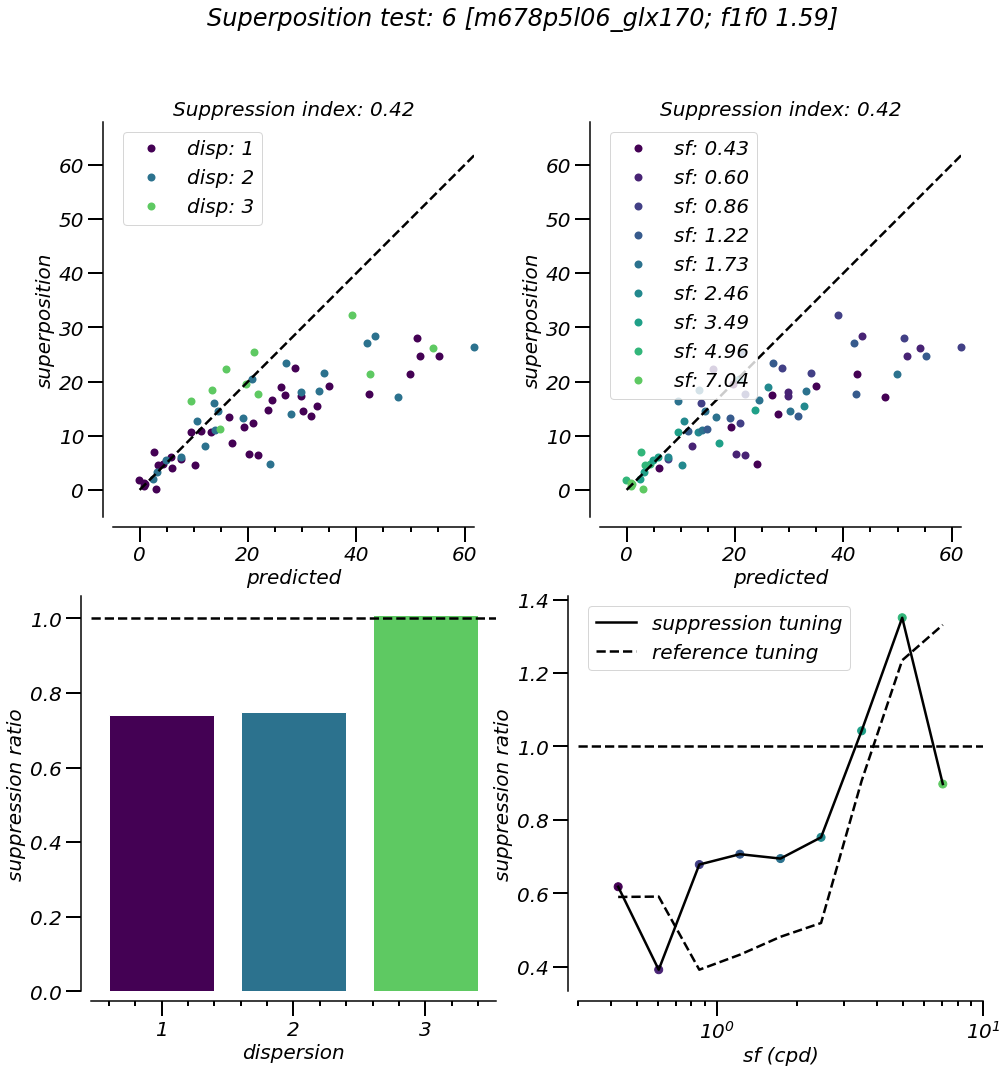

In [53]:
for i in cells:
    try:
        nRows, nCols = 2, 2;
        
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
        
        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1: # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName);
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
        else: # otherwise, if it's complex, just get F0
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=True);
        predResps = resps[2];
    
        respMean = respOrg;
        respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
        # compute SEM, too
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        maxResp = np.maximum(np.nanmax(respMean), np.nanmax(predResps));
        # by disp
        clrs_d = cm.viridis(np.linspace(0,0.75,nDisps-1));
        lbls_d = ['disp: %s' % str(x) for x in range(nDisps)];
        # by sf
        val_sfs = hf.get_valid_sfs(S, disp=1, con=val_con_by_disp[1][0], expInd=expInd) # pick 
        clrs_sf = cm.viridis(np.linspace(0,.75,len(val_sfs)));
        lbls_sf = ['sf: %.2f' % all_sfs[x] for x in val_sfs];
        # by con
        val_con = all_cons;
        clrs_con = cm.viridis(np.linspace(0,.75,len(val_con)));
        lbls_con = ['con: %.2f' % x for x in val_con];

        fSuper, ax = plt.subplots(nRows, nCols, figsize=(8*nCols, 8*nRows))
        sns.despine(fig=fSuper, offset=10)
        
        allMix = [];
        allSum = [];

        for d in range(nDisps):
            if d == 0: # we don't care about single gratings!
                continue; 
            v_cons = np.array(val_con_by_disp[d]);
            n_v_cons = len(v_cons);

            # plot split out by each contrast [0,1]
            for c in reversed(range(n_v_cons)):
                v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
                for s in v_sfs:
                    mixResp = respMean[d, s, v_cons[c]];
                    allMix.append(mixResp);
                    sumResp = predResps[d, s, v_cons[c]];
                    allSum.append(sumResp);
        #             print('condition: d(%d), c(%d), sf(%d):: pred(%.2f)|real(%.2f)' % (d, v_cons[c], s, sumResp, mixResp))
                    # PLOT in by-disp panel
                    if c == 0 and s == v_sfs[0]:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], label=lbls_d[d], clip_on=False)
                    else:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], clip_on=False)
                    # PLOT in by-sf panel
                    sfInd = np.where(np.array(v_sfs) == s)[0][0]; # will only be one entry, so just "unpack"
                    if d == 1 and c == 0:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], label=lbls_sf[sfInd], clip_on=False);
                    else:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], clip_on=False);

            # plot averaged across all cons/sfs (i.e. average for the whole dispersion) [1,0]
            mixDisp = respMean[d, :, :].flatten();
            sumDisp = predResps[d, :, :].flatten();
            mixDisp, sumDisp = zr_rm_pair(mixDisp, sumDisp);
            ax[1, 0].bar(d, np.mean(np.divide(mixDisp, sumDisp)), color=clrs_d[d-1]);
            if d == 1:
                ax[1, 0].set_xlabel('dispersion');
                ax[1, 0].set_ylabel('suppression ratio')
                ax[1, 0].axhline(1, ls='--', color='k')
            
        ### plot averaged across all cons/disps
        sfInds = []; sfRats = [];
        for s in range(len(val_sfs)):
            try: # not all sfs will have legitmate values;
                # only get mixtures (i.e. ignore single gratings)
                mixSf = respMean[1:, val_sfs[s], :].flatten();
                sumSf = predResps[1:, val_sfs[s], :].flatten();
                mixSf, sumSf = zr_rm_pair(mixSf, sumSf);
                sfInds.append(s); sfRats.append(np.mean(np.divide(mixSf, sumSf)))
            except:
                pass
        # get the offset/scale of the ratio so that we can plot a rescaled/flipped version of
        # the high con/single grat tuning for reference...does the suppression match the response?
        offset, scale = np.nanmax(sfRats), np.nanmax(sfRats) - np.nanmin(sfRats);
        sfRef = nan_rm(respMean[0, val_sfs, -1]); # high contrast tuning
        sfRefShift = offset - scale * (sfRef/np.max(sfRef))
        ax[1,1].scatter(all_sfs[val_sfs][sfInds], sfRats, color=clrs_sf[sfInds], clip_on=False)
        ax[1,1].plot(all_sfs[val_sfs][sfInds], sfRats, 'k-', clip_on=False, label='suppression tuning')
        ax[1,1].plot(all_sfs[val_sfs], sfRefShift, 'k--', label='reference tuning', clip_on=False)
        ax[1,1].axhline(1, ls='--', color='k')
        ax[1,1].set_xlabel('sf (cpd)')
        ax[1,1].set_xscale('log')
        ax[1,1].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        ax[1,1].set_ylabel('suppression ratio');
        ax[1,1].legend();
            
        # make a polynomial fit
        hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 

        for j in range(1):
            for jj in range(nCols):
                ax[j, jj].axis('square')
                ax[j, jj].set_xlabel('predicted');
                ax[j, jj].set_ylabel('superposition');
                ax[j, jj].plot([0, 1*maxResp], [0, 1*maxResp], 'k--')
                ax[j, jj].set_xlim((-5, maxResp));
                ax[j, jj].set_ylim((-5, 1.1*maxResp));
                ax[j, jj].set_title('Suppression index: %.2f' % hmm[0])
                ax[j, jj].legend();

        fSuper.suptitle('Superposition test: %d [%s; f1f0 %.2f]' % (which_cell, cellName, f1f0_rat))

        if savePlt:
            save_name = 'cell_%d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
            pdfSv.savefig(fSuper)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

### Predicted tuning

Now, let's get a sense for how the single gratings predict spatial frequency tuning to mixtures.

## Full analysis

Here, we'll try to further develop superposition analysis for all possible cells. Importantly, we can only analyze altExp/ and V1/ experiments (i.e. not V1_orig/) due to the needed construction of the stimulus set. Recall that the superposition analysis seeks to predict the response to mixture stimuli from the responses to constituent gratings when presented alone.

Now, let's gather the same pred/mix responses for all cells

In [ ]:
suppInds = [];
for nm, ind in zip(dataList['unitName'], range(len(dataList['unitName']))):
    
    try:
        # load cell
        expInd = hf.get_exp_ind(dataPath, nm)[0]
        S = hf.np_smart_load(dataPath + nm + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
    except:
        continue;
    
    ### organize responses
    resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
    ### WARNING: WARNING: resps is WITHOUT any rvcAdjustment
    predResps = resps[2];
    rvcFits = hf.get_rvc_fits(dataPath, expInd, ind, rvcName='None');
    spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
    _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);

    respMean = respOrg;
    respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition                                                                                                                         
    # compute SEM, too                                                                                                                                                                                          
    findNaN = np.isnan(respAll);
    nonNaN  = np.sum(findNaN == False, axis=-1);
    respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

    ### organize stimulus information
    all_disps, all_cons, all_sfs = stimVals[0:3];
    nCons, nSfs, nDisps = len(all_cons), len(all_sfs), len(all_disps);
    
    allMix = [];
    allSum = [];

    for d in range(nDisps):
        if d == 0: # we don't care about single gratings!
            continue; 
        v_cons = np.array(val_con_by_disp[d]);
        n_v_cons = len(v_cons);

        for c in reversed(range(n_v_cons)):
            v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
            for s in v_sfs:
                mixResp = respMean[d, s, v_cons[c]];
                allMix.append(mixResp);
                sumResp = predResps[d, s, v_cons[c]];
                allSum.append(sumResp);
    
    hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 
    suppInds.append(hmm[0])
    